# Treatment of Resonant Elastic X-ray Scattering spectra by artificial neural networks

In this notebook, we delve into the task of processing Resonant Elastic X-ray Scattering (REXS) data acquired at the European Synchrotron Radiation Facility (ESRF). Our goal is to determine the occupation of both tetragonal (T<sub>d</sub>) and (O<sub>h</sub>) sites by the two cationic species, Fe and V.

The cationic distribution can be described by means of the following expression: (Fe<sub>1-x</sub>V<sub>x</sub>)<sub>Td</sub> (V<sub>2(1-y)</sub>Fe<sub>y</sub>)<sub>Oh</sub> O<sub>4</sub>; with x representing the V insertion into the T<sub>d</sub> site and y the Fe insertion into the O<sub>h</sub> site. Both parameters quantify the structural deviation from the FeV<sub>2</sub>O<sub>4</sub> structure.

For that purpose, we will be usin a sequential model based on an artificial neural network. The study focuses on a tetragonal spinel structure with a space group of 141, and spectra were collected at the reflection 303. THe process has been schematised in the figure below.

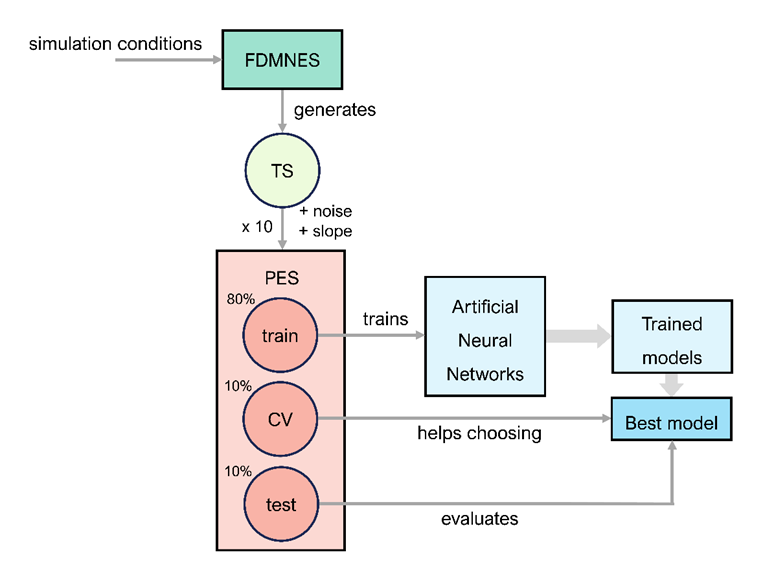

To achieve our objective, we first simulated theoretical spectra with varying atomic positions by using the ab initio software FDMNES (https://fdmnes.neel.cnrs.fr/). Each thoretical spectrum (TS), with their (x, y) labels, will suffer a noise adding process, leading to pseudoexperimenal spectrum (PES).

Among all possible (x, y) labels, the data will be divided into a train (80%) dataset, for the model training; a cross-validation (CV) dataset (10%), for the choice of the best model architecture; and a test set (10%) for the final model evaluation. The TS-to-PES process will be conducted 10 times on each different label - data augmentation, better statistics.

Then, the train dataset was used to train the different models. We have used models with different activation functions ('ReLU' or 'sigmoid') and varying numbers of neurons per layer.

Finally, we used the models we obtained to predict the cationic occupation in an experimental spectrum. While there is still room for improvement in the fitting process, this notebook serves as a demonstration of the feasibility of using an IA model to fit REXS spectra. To the best of our knowledge, this is the first attempt to apply an AI models for the refinement of REXS spectra.
***

We begin by importing the relevant modules:

In [1]:
# Deep Learning framework
import tensorflow as tf

# Numerical computation and array manipulation
import numpy as np

# Data manipulation and analysis
import pandas as pd

# Operating system-related functionalities
import os

# Data visualization
import matplotlib.pyplot as plt

# Handling file paths
from pathlib import Path

# Tools for curve fitting
from scipy.optimize import curve_fit

# Interpolation functions
from scipy.interpolate import interp1d

# Signal processing tools
from scipy.signal import savgol_filter 

# Generating random numbers and samples
from random import random, randint, sample

# Data visualization (statistical plots)
import seaborn as sns

# Progress bars for loops
import tqdm

# Splitting data into training and testing sets
from sklearn.model_selection import train_test_split

# Evaluation metric for regression models
from sklearn.metrics import mean_squared_error

# Pandas option to suppress warnings when manipulating data
pd.options.mode.chained_assignment = None  # default='warn'

Definition of home working directory:

In [2]:
home_wd = os.getcwd()

# Theoretical spectra treatment

The aim of this part is to find the theoretical spectra, treat them and obtain valuable input for the IA model. We start by defining the limits of the borders that we will exploit for the refinement of the cationic occupations. In this case, it corresponds to the XANES (near-the-edge) domain.

In [3]:
index_start = 25 # before the edge
index_end = 50 # after the edge

We then define a linear function that we will use to supress the linear contribution of the spectra:

In [4]:
def lin_fit(X, a, b):
    """Definition of a linear function in order to perform linear fits on the data."""
    
    return [x*a + b for x in X]

We create a function that transforms the theoretical spectra into pseudo-experimental. For that purpose:

- We add random noise

- We filter data so it is not continuous
- We add random slope

In [5]:
def TS_to_PES(xy, eV_step):
    """Transform a theoretical spectrum into a pseudo-experimental one"""
    
    # Filtering to select just a few points:

    x_filtered = np.array([E - xy_filtered[xy_filtered['I(105)0ss'] == xy_filtered['I(105)0ss'].min()]['Energy'] 
                           for E in xy_filtered['Energy']]) # we add the energy shift 

    # Normalisation:
    y_filtered = np.array([(intensity - xy_filtered['I(105)0ss'].min())/(xy_filtered['I(105)0ss'].max() - xy_filtered['I(105)0ss'].min())
                           for intensity in xy_filtered['I(105)0ss']])
    
    # Slope adding
    slope = (1 +  random())*(slope_strength)*(-1)**randint(0,1) # slope for the spectrym
    
    y_filtered = np.array([intensity*(1 + random()*noise_factor) + x_filtered[j]*slope
                           for j, intensity in enumerate(y_filtered)]) # we add background noise of 2%
    
    return x_filtered, y_filtered

In [6]:
def TS_to_PES(file, column, eV_step, E_EXAFS):
    """Transform a theoretical spectrum into a pseudo-experimental one.
    
    Args:
    ----
    - file name (str): name of the file to treat 
    - column of interest (str): column of the dataframe where the data is
    - eV_step (int): energy step which that the data willm be taken
    - E_EXAFS (float): energy value beyond which the EXAFS domain is - for the linear correction
    
    Returns
    -------
    - data array of intensities with added noise
    """
    
    os.chdir(Path(home_wd, 'XANES new', 'XANES')) # File where the data is

    DF = pd.read_csv(file, sep='  ', engine='python') # Raw data
    real_header = list(filter(lambda x: (x.startswith('Unnamed') == False), DF.columns)) # real header of the data
    
    # Some modifications to avoid errors:
    DF.dropna(axis=1, inplace=True)
    DF.columns = real_header
    df = DF
    
    df['filtered'] = df[column] # Column of interest

    zero_index = df[df['filtered'] == df['filtered'].min()].index[0] # index for the minimum 
    df['x'] = df['Energy'] - df.loc[zero_index, 'Energy'] # Energy shift correction - minimum at 0
    df = df.loc[zero_index-index_start:zero_index+index_end] # Selection of the energy domain

    df['y'] = np.array([(intensity - df[column].min())/(df[column].max() - df[column].min())
                           for intensity in df[column]]) # Normalisation of the intensity
    
    par, cov = curve_fit(lin_fit, df[df['x'] > E_EXAFS]['x'], df[df['x'] > E_EXAFS]['y']) # linear fit
    df['y_cor'] = df['y'] - lin_fit(df['x'], par[0], par[1]) # linear correction

    df['y_bruit'] = [intensity*(1 + random()*noise_factor*df['y_cor'].min()) for intensity in df['y_cor'].values] # noise adding
    
    filtered_values = df
    
    filtered_values['y_cor_t'] = np.array([(intensity - filtered_values['y_bruit'].min())/(filtered_values['y_bruit'].max() - filtered_values['y_bruit'].min())
                           for intensity in filtered_values['y_bruit']]) # final normalisation
    
    return filtered_values['y_cor_t'].values # output

In [7]:
# Parameters for the PES generation:

noise_factor = 0.5 # how noisy the data will be
E_shift_factor = 1 # how strong the E shift will be
slope_strength = 0.001 # how close to one the slope will be - 0.001 seems reasonable

We define all possible combinations for x and y parameters, we stop at the upper limit of 0.85:

In [8]:
X_simulations = np.arange(0.00, 0.85, 0.02)
Y_simulations = np.arange(0.00, 0.85, 0.02)

Generate dataframe with all combinations:

In [9]:
os.chdir(Path(home_wd, 'XANES new', 'XANES')) # Folder where the data is

file_df = pd.DataFrame(list(filter(lambda x: 'conv' in x, os.listdir())), columns=['file',])

In [10]:
file_df['x'] = file_df['file'].apply(lambda x: x[x.find('x')+2:x.find('y')-1]).astype(float) # we define x
file_df['y'] = file_df['file'].apply(lambda x: x[x.find('y')+2:x.find('z')-1]).astype(float) # we define y

file_df = file_df[(file_df['x'] < 0.86) & (file_df['y'] < 0.86)].reset_index().drop('index', axis=1)

In [11]:
file_df.head()

,file,x,y
0,"(x=0.0,y=0.0,z=0)_conv.txt",0.0,0.00
1,"(x=0.0,y=0.02,z=0)_conv.txt",0.0,0.02
2,"(x=0.0,y=0.04,z=0)_conv.txt",0.0,0.04
3,"(x=0.0,y=0.06,z=0)_conv.txt",0.0,0.06
4,"(x=0.0,y=0.08,z=0)_conv.txt",0.0,0.08


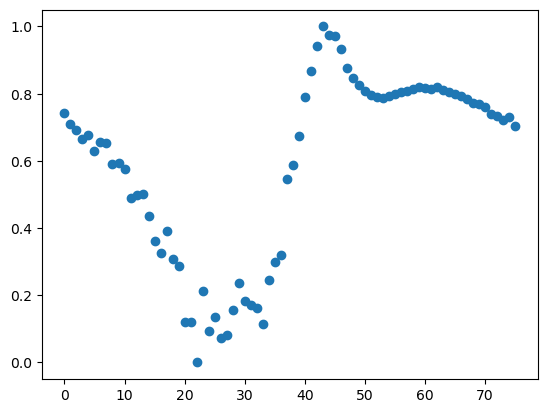

In [12]:
y_PES = TS_to_PES(file_df.loc[0, 'file'], 'I(105)0ss', 1, 10)
plt.plot(list(range(len(y_PES))), y_PES, 'o')

To avoid extrapolation problems, we take the borders away so that they fall into tranining dataset.

In [13]:
x_min_y_min = file_df[(file_df['x'] == file_df['x'].min()) & (file_df['y'] == file_df['y'].min())]
x_max_y_max = file_df[(file_df['x'] == file_df['x'].max()) & (file_df['y'] == file_df['y'].max())]

x_min_y_max = file_df[(file_df['x'] == file_df['x'].min()) & (file_df['y'] == file_df['y'].max())]
x_max_y_min = file_df[(file_df['y'] == file_df['y'].min()) & (file_df['x'] == file_df['x'].max())]

borders = pd.concat((x_min_y_min, x_max_y_max, x_min_y_max, x_max_y_min))
borders

,file,x,y
0,"(x=0.0,y=0.0,z=0)_conv.txt",0.00,0.00
1848,"(x=0.84,y=0.84,z=0)_conv.txt",0.84,0.84
42,"(x=0.0,y=0.84,z=0)_conv.txt",0.00,0.84
1806,"(x=0.84,y=0.0,z=0)_conv.txt",0.84,0.00


From the exclusive combinations dataset, we take these values away:

In [14]:
cut_ex_df = file_df.drop(borders.index)

From the resulting exclusive combinations, we sample a number for the training, and the rest for the set:

In [15]:
alpha = 0.9 # number of elements that will go to the training dataset

training_index = sample(list(cut_ex_df.index), int(len(cut_ex_df)*alpha))
first_split = set(cut_ex_df.index) - set(training_index)

From this first split, half will go to CV and half to tests:

In [16]:
index_CV_1 = sample(list(first_split), len(first_split)//2)
index_test_1 = first_split - set(index_CV_1)

We group the resulting training set with the borders:

In [17]:
training_index += list(borders.index)

For every (y, z) combination, we will repeat the T to PES procedure 20 times:

In [18]:
repetitions = 5 # number of times each row will be repeated - data augmentation

We define a function which, from a list of indexes, is able to find the theoretical data and then transform it to PES, giving a dataframe as an output.

In [19]:
def index_sweeper(index_list):
    X = pd.DataFrame(columns=range(index_end+index_start+1))
    y_model = pd.DataFrame(columns=range(2))
    
    for repetition in tqdm.trange(repetitions):
        for index in index_list:
            file =  file_df.loc[index]['file']
            x = file_df.loc[index]['x']
            y = file_df.loc[index]['y']
        
            x_generated = TS_to_PES_2(file, 'I(105)0ss', 1, 10)
            try:
                X.loc[len(X)] = x_generated
            except Exception as e:
                print(e, f' happended for {file}')
            y_model.loc[len(y_model)] = (x, y)
    
    return X, y_model    

We only run the following lines the first time, the rest we fetch the data:

In [20]:
#X_train, y_train = index_sweeper(training_index)

In [21]:
#X_cv1, y_cv1 = index_sweeper(index_CV_1)

In [22]:
#X_t1, y_t1 = index_sweeper(index_test_1)

In [23]:
os.chdir(Path(home_wd, 'export_9')) # Folder where the data will be stored

In [24]:
"""
X_train.to_csv('X_train.csv')
y_train.to_csv('y_train.csv')

X_cv1.to_csv('X_cv.csv')
y_cv1.to_csv('y_cv.csv')

X_t1.to_csv('X_t.csv')
y_t1.to_csv('y_t.csv')
"""

"\nX_train.to_csv('X_train.csv')\ny_train.to_csv('y_train.csv')\n\nX_cv1.to_csv('X_cv.csv')\ny_cv1.to_csv('y_cv.csv')\n\nX_t1.to_csv('X_t.csv')\ny_t1.to_csv('y_t.csv')\n"

In [25]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')

X_cv1 = pd.read_csv('X_cv.csv')
y_cv1 = pd.read_csv('y_cv.csv')

X_t1 = pd.read_csv('X_t.csv')
y_t1 = pd.read_csv('y_t.csv')

In our case, the data was already generated. In that case, the following line must be executed to transform the data in a format suitable for the further treatment:

In [26]:
X_train_final = X_train.to_numpy()[:, 1:]
y_train_final = y_train.to_numpy()[:, 1:]

X_cv_final = X_cv1.to_numpy()[:, 1:]
y_cv_final = y_cv1.to_numpy()[:, 1:]

X_t_final = X_t1.to_numpy()[:, 1:]
y_t_final = y_t1.to_numpy()[:, 1:]

We verify the dimensions of each of the datasets:

In [27]:
print('Training dataset: ', X_train_final.shape, y_train_final.shape)

print(X_cv_final.shape, y_cv_final.shape)
print(X_t_final.shape, y_t_final.shape)


Training dataset:  (8320, 76) (8320, 2)
(460, 76) (460, 2)
(465, 76) (465, 2)


# Experimental data treatment

The goal of this part is the import and treatment of experimental data

In [28]:
# The exp data is in the parent directory, defined as follows:

os.chdir(home_wd)
os.chdir('..')
parent_directory = os.getcwd()
os.chdir(home_wd)

Function to read an experimental spectrum:

In [31]:
def scan_grab(scan_n):
    """Read data for a specified scan from a file and returns the data in a pandas DataFrame format.

    Args:
    ----
    - scan_n (int): An integer that specifies the number of the scan to be grabbed from the edf file.
    
    Returns
    -------
    - pd.DataFrame: A pandas DataFrame that contains the data for the specified scan.
    
    """

    # Spec file name hardcoded in the function
    os.chdir(parent_directory)
    file = 'kappa.07Feb23'
    
    # Data import and treat
    with open(file, 'r') as f:
        lines = f.readlines()

    for i, line in enumerate(lines):
        if str(line).startswith(f"#S {scan_n}"):
            break
    
    scan_1 = []
    for line in lines[i:]:
        if str(line).startswith('#L'):
            header_line = str(line)[3:].split('  ')
        elif not str(line).startswith('#S ' + str(scan_n + 1)):
            if not str(line).startswith('#'):
                scan_1.append(pd.Series(str(line).replace(' ', ',').replace('\n', '').split(',')))
        else:
            break
      
    # Definition of a dataframe with the data and the correct header
    df = pd.DataFrame(data=scan_1).dropna().astype('float64')
    df.columns = header_line
    os.chdir(home_wd)

    return df

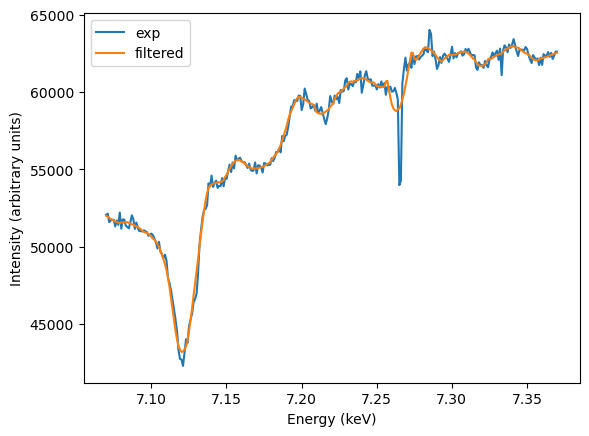

In [33]:
# test with random file
exp_scan = scan_grab(109)

energy_values = exp_scan['Energy']
intensity_values = exp_scan['roi3']
filtered_values = savgol_filter(intensity_values, 18, 3)

exp_scan['filtered'] = filtered_values

plt.plot(energy_values, intensity_values, label='exp')
plt.plot(energy_values, filtered_values, label='filtered')

plt.xlabel('Energy (keV)')
plt.ylabel('Intensity (arbitrary units)')

plt.legend()

In [ ]:
Complete function 

In [37]:
def scan_treat(scan_n, column, E_EXAFS, threshold, n_neigh):
    """Read data for a specified scan from a file and treats it.

    Args:
    ----
    - scan_n (int): An integer that specifies the number of the scan to be grabbed from the edf file.
    - column (str): column of the dataframe possessing the information.
    - E_EXAFS(float): Energy beyond which the linear fit is made.
    - Threeshold (float): strength of the outlier detector mechanism.
    - n_neigh (int): number of neighbors for the outlier detector algorithm.
    
    Returns
    -------
    - Two columns of the df (pd object): Energy and Intensity.
    
    """
    
    # Fecth the data from the experiment:
    exp_values = scan_grab(scan_n)
    exp_values['filtered'] = exp_values[column]
    
    # Calculate the distance between the data for the outlier detection
    exp_values['distance'] = d_outlier_detector(exp_values.reset_index(), n_neigh, 'filtered') # function to detect outliers
    exp_values['outlier'] = exp_values['distance'] > threshold * exp_values['distance'].std()
    exp_values = outlier_replace(exp_values.reset_index(), n_neigh, 'filtered') # function to replace outliers
   
    # Energy_shidt correction
    energy_at_minimum = exp_values[exp_values['filtered'] == exp_values['filtered'].min()]['Energy'].values[0]
    zero_index = exp_values[exp_values['filtered'] == exp_values['filtered'].min()].index[0] # index for the minimum 
    
    # Border correction:
    exp_values = exp_values.loc[zero_index-index_start:zero_index+index_end]

    # Normalisation
    exp_values['y'] = np.array([(intensity - exp_values['filtered'].min())/(exp_values['filtered'].max() - exp_values['filtered'].min())
                           for intensity in exp_values['filtered']])
    exp_values['y'] = savgol_filter(exp_values['y'], 5, 3)
    
    # Values to eV
    exp_values['x'] = (exp_values['Energy'] - energy_at_minimum)*1000
    
    # Linear fit, EXAFS correction
    par, cov = curve_fit(lin_fit, exp_values[exp_values['x'] > E_EXAFS]['x'], exp_values[exp_values['x'] > E_EXAFS]['y'])
    exp_values['y_cor_exp'] = exp_values['y'] - lin_fit(exp_values['x'], par[0], par[1])
    
    # Final normalisation
    filtered_values = exp_values
    filtered_values['y_cor_exp'] = np.array([(intensity - filtered_values['y_cor_exp'].min())/(filtered_values['y_cor_exp'].max() - filtered_values['y_cor_exp'].min())
                           for intensity in filtered_values['y_cor_exp']])    
    return filtered_values[['x', 'y_cor_exp']]

In [38]:
def d_outlier_detector(X_exp, n_neigh, column):
    """
    Detect outliers.
    
    Args:
    ----
    - X_exp (pd.df) with intensities.
    - n_neigh (int): number of neighbours for outlier detection
    - column: column of interest.
    
    Returns
    -------
    - np.array saying where outliers are
    
    """
    result_np = np.zeros(len(X_exp))
    index_range = list(range(len(X_exp)))
    for i in range(len(X_exp)):
        
        # Take closest neighbours
        try:
            indexes = np.array(range(i - n_neigh//2, i + n_neigh//2 + 1))
            good_indexes = np.where(np.isin(indexes, index_range), indexes, -1)
            tail = (-1, 0) if list(map(lambda x: x in index_range, indexes))[0] else (0, -1)
            ind_nei = np.where(np.isin(indexes, index_range), indexes, index_range[tail[0]] + good_indexes[good_indexes>=0][tail[1]] - indexes)

            short_list = X_exp.loc[ind_nei]
            result_np[i] = abs(X_exp.loc[i][column] - short_list[column].mean())
        except BaseException as e:
            print(f'Problem with index {i}: ', e)
        
    return result_np

In [39]:
def outlier_replace(X_exp, n_neigh, column):
    """
    Replace outliers with close interpolated values.
    
    Args:
    ----
    - X_exp (pd.df) with intensities.
    - n_neigh (int): number of neighbours for outlier detection
    - column: column of interest.
    
    Returns
    -------
    - pd.df of corrected values
    
    """
    
    X_exp = X_exp.reset_index()
    index_range = list(range(len(X_exp)))
    
    outliers = X_exp[X_exp['outlier']].index
    
    for outlier in outliers:
        indexes = np.array(range(outlier - n_neigh//2, outlier + n_neigh//2 + 1))
        good_indexes = np.where(np.isin(indexes, index_range), indexes, -1)
        tail = (-1, 0) if list(map(lambda x: x in index_range, indexes))[0] else (0, -1)
        ind_nei = np.where(np.isin(indexes, index_range), indexes, index_range[tail[0]] + good_indexes[good_indexes>=0][tail[1]] - indexes)
        
        ind_good_nei = ind_nei[~np.isin(ind_nei, outliers)]
        X_exp[column].loc[outlier] = X_exp.loc[ind_good_nei][column].mean()
        #print('Outlier at ', X_exp.loc[outlier]['Energy'], 'eV')
        
    return X_exp

In [40]:
X_exp = scan_treat(263, 'roi3', 10, 2, 10)

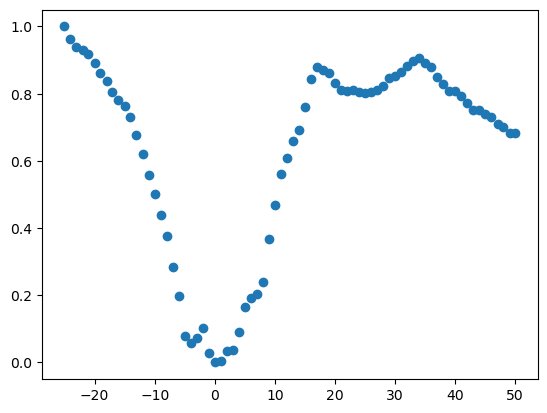

In [41]:
plt.plot(X_exp['x'], X_exp['y_cor_exp'],'o')

We check the equivalence of the dimensions of the PES and experimental spectra:

In [43]:
print(X_train_final[0].shape)
print(X_exp['x'].shape)

(76,)
(76,)


# Neural networks

We hereby define 40 model architectures to refine the data:
***
| model | activation | layers | neurons | architecture              |
|-------|------------|--------|---------|---------------------------|
| 1     | ReLU       | 3      | 82      | 64 16 2                   |
| 2     | sigmoid    | 3      | 82      | 64 16 2                   |
| 3     | ReLU       | 4      | 162     | 32 64 64 2                |
| 4     | sigmoid    | 4      | 162     | 32 64 64 2                |
| 5     | ReLU       | 3      | 50      | 16 32 2                   |
| 6     | sigmoid    | 3      | 50      | 16 32 2                   |
| 7     | ReLU       | 3      | 66      | 32 32 2                   |
| 8     | sigmoid    | 3      | 66      | 32 32 2                   |
| 9     | ReLU       | 5      | 258     | 32 64 128 32 2            |
| 10    | sigmoid    | 5      | 258     | 32 64 128 32 2            |
| 11    | ReLU       | 5      | 354     | 32 64 128 128 2           |
| 12    | sigmoid    | 5      | 354     | 32 64 128 128 2           |
| 13    | ReLU       | 5      | 482     | 256 128 64 32 2           |
| 14    | ReLU       | 6      | 994     | 512 256 128 64 32 2      |
| 15    | ReLU       | 6      | 1474    | 512 512 256 128 64 32 2  |
| 16    | ReLU       | 6      | 1502    | 128 256 526 526 64 2     |
| 17    | ReLU       | 5      | 962     | 512 256 128 64 2         |
| 18    | sigmoid    | 5      | 482     | 256 128 64 32 2          |
| 19    | sigmoid    | 6      | 994     | 512 256 128 64 32 2      |
| 20    | sigmoid    | 6      | 1474    | 512 512 256 128 64 32 2  |
| 21    | sigmoid    | 6      | 1502    | 128 256 526 526 64 2     |
| 22    | sigmoid    | 5      | 962     | 512 256 128 64 2         |
| 23    | ReLU       | 3      | 34      | 16 16 2                   |
| 24    | sigmoid    | 3      | 34      | 16 16 2                   |
| 25    | ReLU       | 4      | 42      | 16 16 8 2                |
| 26    | sigmoid    | 4      | 42      | 16 16 8 2                |
| 27    | ReLU       | 4      | 30      | 16 8 4 2                 |
| 28    | sigmoid    | 4      | 30      | 16 8 4 2                 |
| 29    | ReLU       | 3      | 14      | 8 4 2                    |
| 30    | sigmoid    | 3      | 14      | 8 4 2                    |
| 31    | ReLU       | 3      | 26      | 8 16 2                   |
| 32    | sigmoid    | 3      | 26      | 8 16 2                   |
| 33    | ReLU       | 3      | 26      | 16 8 2                   |
| 34    | sigmoid    | 3      | 26      | 16 8 2                   |
| 35    | ReLU       | 3      | 50      | 32 16 2                   |
| 36    | sigmoid    | 3      | 50      | 32 16 2                   |
| 37    | ReLU       | 5      | 62      | 32 16 8 4 2              |
| 38    | sigmoid    | 5      | 62      | 32 16 8 4 2              |
| 39    | ReLU       | 4      | 58      | 32 16 8 2                |
| 40    | sigmoid    | 4      | 58      | 32 16 8 2                |


In [48]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2)
])

m1 = ('relu', 64, 16, 2)

In [49]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='sigmoid', input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dense(2)
])

m2 = ('sigmoid', 64, 16, 2)

In [50]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)
])

m3 = ('relu', 32, 64, 64, 2)

In [51]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='sigmoid', input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(2)
])

m4 = ('sigmoid', 32, 64, 64, 2)

In [52]:
model_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2)
])

m5 = ('relu', 16, 32, 2)

In [53]:
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='sigmoid', input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(2)
])

m6 = ('sigmoid', 16, 32, 2)

In [56]:
# evaluator, different models. needs an axs object:
def model_evaluation_n(i, model, axs):
    ############# VIRGIN DATA #############
    # MSE for the cross-validation dataset:
    cv_mse_1 = mean_squared_error(y_cv_final, model.predict(X_cv_final, verbose=False))
    t_mse_1 = mean_squared_error(y_t_final, model.predict(X_t_final, verbose=False))

    # differences dataframe between predicted values of CV and real values:
    differences_1 = pd.DataFrame((y_cv_final - model.predict(X_cv_final, verbose=False)), columns=('y', 'z'))
    differences_2 = pd.DataFrame((y_t_final - model.predict(X_t_final, verbose=False)), columns=('y', 'z'))
    d1_y = differences_1['y'].std()
    d1_z = differences_1['z'].std()
    
    sns.histplot(differences_1, ax=axs[0], palette='bright')
    axs[0].locator_params(axis='x', nbins=6)
    axs[0].axvline(0, color='black')
    
    sns.histplot(differences_2, ax=axs[1], palette='bright')
    axs[1].locator_params(axis='x', nbins=6)
    axs[1].axvline(0, color='black')
    
    axs[0].set_title(str(i+1) + ' cross validation')
    axs[1].set_title(str(i+1) + ' test')
    
    axs[0].set_xlim(-0.5, 0.5)
    axs[1].set_xlim(-0.5, 0.5)
    

In [63]:
model_7 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2)
])

m7 = ('relu', 32, 32, 2)

In [64]:
model_8 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='sigmoid', input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(2)
])

m8 = ('sigmoid', 32, 32, 2)

In [65]:
model_9 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2)
])

m9 = ('relu', 32, 64, 128, 32, 2)

In [66]:
model_10 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='sigmoid', input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(2)
])

m10 = ('sigmoid', 32, 64, 128, 32, 2)

In [67]:
model_11 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(len(X_train_final[0]), )), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

m11 = ('relu', 32, 64, 128, 128, 2)

In [68]:
model_12 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='sigmoid', input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(2)
])

m12 = ('sigmoid', 32, 64, 128, 128, 2)

In [69]:
model_13 = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2)
])

m13 = ('relu', 256, 128, 64, 32, 2)

In [70]:
# And the rest all at once:
model_14 = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2)
])

m14 = ('relu', 512, 256, 128, 64, 32, 2)

model_15 = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)
])

m15 = ('relu', 512, 512, 256, 128, 64, 2)


model_16 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(526, activation='relu'),
    tf.keras.layers.Dense(526, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)
])

m16 = ('relu', 128, 256, 526, 526, 64, 2)

# Define the model
model_13 = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2)
])

m13 = ('relu', 256, 128, 64, 32, 2)

model_14 = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2)
])

m14 = ('relu', 512, 256, 128, 64, 32, 2)

model_15 = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)
])

m15 = ('relu', 512, 512, 256, 128, 64, 2)


model_16 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(526, activation='relu'),
    tf.keras.layers.Dense(526, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)
])

m16 = ('relu', 128, 256, 526, 526, 64, 2)

In [71]:
model_17 = tf.keras.Sequential([
    tf.keras.layers.Dense(512, input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(2)
])
m17 = ('relu', 512, 256, 128, 64, 2)

model_18 = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='sigmoid', input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(2)
])


m18 = ('sigmoid', 256, 128, 64, 32, 2)

model_19 = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='sigmoid', input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.Dense(256, activation='sigmoid'),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(2)
])

m19 = ('sigmoid', 512, 256, 128, 64, 32, 2)

model_20 = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='sigmoid', input_shape=(len(X_train_final[0]), )),
    tf.keras.layers.Dense(512, activation='sigmoid'),
    tf.keras.layers.Dense(256, activation='sigmoid'),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(2)
])

m20 = ('sigmoid', 512, 512, 256, 128, 64, 2)

model_21 = tf.keras.Sequential([
	tf.keras.layers.Dense(128, activation='sigmoid', input_shape=(len(X_train_final[0]), )),
	tf.keras.layers.Dense(256, activation='sigmoid'),
	tf.keras.layers.Dense(526, activation='sigmoid'),
	tf.keras.layers.Dense(526, activation='sigmoid'),
	tf.keras.layers.Dense(64, activation='sigmoid'),
	tf.keras.layers.Dense(2)
])


m21 = ('sigmoid', 128, 256, 526, 526, 64, 2)

model_22 = tf.keras.Sequential([
	tf.keras.layers.Dense(512, input_shape=(len(X_train_final[0]), )),
	tf.keras.layers.BatchNormalization(),
	tf.keras.layers.Activation('sigmoid'),
	tf.keras.layers.Dropout(0.2),

	tf.keras.layers.Dense(256),
	tf.keras.layers.BatchNormalization(),
	tf.keras.layers.Activation('sigmoid'),
	tf.keras.layers.Dropout(0.2),

	tf.keras.layers.Dense(128),
	tf.keras.layers.BatchNormalization(),
	tf.keras.layers.Activation('sigmoid'),
	tf.keras.layers.Dropout(0.2),

	tf.keras.layers.Dense(64),
	tf.keras.layers.BatchNormalization(),
	tf.keras.layers.Activation('sigmoid'),
	tf.keras.layers.Dropout(0.2),

	tf.keras.layers.Dense(2)
])
m22 = ('sigmoid', 512, 256, 128, 64, 2)

# Define the model
model_23 = tf.keras.Sequential([
	tf.keras.layers.Dense(16, activation='relu', input_shape=(len(X_train_final[0]), )),
	tf.keras.layers.Dense(16, activation='relu'),
	tf.keras.layers.Dense(2)
])

m23 = ('relu', 16, 16, 2)

model_24 = tf.keras.Sequential([
	tf.keras.layers.Dense(16, activation='sigmoid', input_shape=(len(X_train_final[0]), )),
	tf.keras.layers.Dense(16, activation='sigmoid'),
	tf.keras.layers.Dense(2)
])

m24 = ('sigmoid', 16, 16, 2)

model_25 = tf.keras.Sequential([
	tf.keras.layers.Dense(16, activation='relu', input_shape=(len(X_train_final[0]), )),
	tf.keras.layers.Dense(16, activation='relu'),
	tf.keras.layers.Dense(8, activation='relu'),
	tf.keras.layers.Dense(2)
])

m25 = ('relu', 16, 16, 8, 2)

model_26 = tf.keras.Sequential([
	tf.keras.layers.Dense(16, activation='sigmoid', input_shape=(len(X_train_final[0]), )),
	tf.keras.layers.Dense(16, activation='sigmoid'),
	tf.keras.layers.Dense(8, activation='sigmoid'),
	tf.keras.layers.Dense(2)
])

m26 = ('sigmoid', 16, 16, 8, 2)

model_27 = tf.keras.Sequential([
	tf.keras.layers.Dense(16, activation='relu', input_shape=(len(X_train_final[0]), )),
	tf.keras.layers.Dense(8, activation='relu'),
	tf.keras.layers.Dense(4, activation='relu'),
	tf.keras.layers.Dense(2)
])

m27 = ('relu', 16, 8, 4, 2)

model_28 = tf.keras.Sequential([
	tf.keras.layers.Dense(16, activation='sigmoid', input_shape=(len(X_train_final[0]), )),
	tf.keras.layers.Dense(8, activation='sigmoid'),
	tf.keras.layers.Dense(4, activation='sigmoid'),
	tf.keras.layers.Dense(2)
])

m28 = ('sigmoid', 16, 8, 4, 2)

model_29 = tf.keras.Sequential([
	tf.keras.layers.Dense(8, activation='relu', input_shape=(len(X_train_final[0]), )),
	tf.keras.layers.Dense(4, activation='relu'),
	tf.keras.layers.Dense(2)
])

m29 = ('relu', 8, 4, 2)

model_30 = tf.keras.Sequential([
	tf.keras.layers.Dense(8, activation='sigmoid', input_shape=(len(X_train_final[0]), )),
	tf.keras.layers.Dense(4, activation='sigmoid'),
	tf.keras.layers.Dense(2)
])

m30 = ('sigmoid', 8, 4, 2)

model_31 = tf.keras.Sequential([
	tf.keras.layers.Dense(8, activation='relu', input_shape=(len(X_train_final[0]), )),
	tf.keras.layers.Dense(16, activation='relu'),
	tf.keras.layers.Dense(2)
])

m31 = ('relu', 8, 16, 2)

model_32 = tf.keras.Sequential([
	tf.keras.layers.Dense(8, activation='sigmoid', input_shape=(len(X_train_final[0]), )),
	tf.keras.layers.Dense(16, activation='sigmoid'),
	tf.keras.layers.Dense(2)
])

m32 = ('sigmoid', 8, 16, 2)

model_33 = tf.keras.Sequential([
	tf.keras.layers.Dense(16, activation='relu', input_shape=(len(X_train_final[0]), )),
	tf.keras.layers.Dense(8, activation='relu'),
	tf.keras.layers.Dense(2)
])

m33 = ('relu', 16, 8, 2)

model_34 = tf.keras.Sequential([
	tf.keras.layers.Dense(16, activation='sigmoid', input_shape=(len(X_train_final[0]), )),
	tf.keras.layers.Dense(8, activation='sigmoid'),
	tf.keras.layers.Dense(2)
])

m34 = ('sigmoid', 16, 8, 2)

model_35 = tf.keras.Sequential([
	tf.keras.layers.Dense(32, activation='relu', input_shape=(len(X_train_final[0]), )),
	tf.keras.layers.Dense(16, activation='relu'),
	tf.keras.layers.Dense(2)
])

m35 = ('relu', 32, 16, 2)


model_36 = tf.keras.Sequential([
	tf.keras.layers.Dense(32, activation='sigmoid', input_shape=(len(X_train_final[0]), )),
	tf.keras.layers.Dense(16, activation='sigmoid'),
	tf.keras.layers.Dense(2)
])

m36 = ('sigmoid', 32, 16, 2)

model_37 = tf.keras.Sequential([
	tf.keras.layers.Dense(32, activation='relu', input_shape=(len(X_train_final[0]), )),
	tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
	tf.keras.layers.Dense(2)
])

m37 = ('relu', 32, 16, 8, 4, 2)

model_38 = tf.keras.Sequential([
	tf.keras.layers.Dense(32, activation='sigmoid', input_shape=(len(X_train_final[0]), )),
	tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dense(8, activation='sigmoid'),
    tf.keras.layers.Dense(4, activation='sigmoid'),
	tf.keras.layers.Dense(2)
])

m38 = ('sigmoid', 32, 16, 8, 4, 2)

model_39 = tf.keras.Sequential([
	tf.keras.layers.Dense(32, activation='relu', input_shape=(len(X_train_final[0]), )),
	tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
	tf.keras.layers.Dense(2)
])

m39 = ('relu', 32, 16, 8, 2)


model_40 = tf.keras.Sequential([
	tf.keras.layers.Dense(32, activation='sigmoid', input_shape=(len(X_train_final[0]), )),
	tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dense(8, activation='sigmoid'),
	tf.keras.layers.Dense(2)
])

m40 = ('sigmoid', 32, 16, 8, 2)

We repeat the same for all models:

In [72]:
model_tuple = (model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, model_9, model_10, 
               model_11, model_12, model_13, model_14, model_15, model_16, model_17, model_18, model_19, model_20, 
               model_21, model_22, model_23, model_24, model_25, model_26, model_27, model_28, model_29, model_30, 
               model_31, model_32, model_33, model_34, model_35, model_36, model_37, model_38, model_39, model_40)

In [86]:
mtuple = (m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, 
               m11, m12, m13, m14, m15, m16, m17, m18, m19, m20, 
               m21, m22, m23, m24, m25, m26, m27, m28, m29, m30, 
               m31, m32, m33, m34, m35, m36, m37, m38, m39, m40)

In [87]:
# In order to train the models, the following lines should be executed:

"""
for i_m, model in enumerate(tqdm.tqdm((model_tuple ))):
    print(f'moderl_{i_m+1}')
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.fit(X_train_final, y_train_final, epochs=15000, batch_size=(len(X_train_final[0])), verbose=False)
    model.save(Path(export, f"model_{i_m+1}"))
"""

'\nfor i_m, model in enumerate(tqdm.tqdm((model_tuple ))):\n    print(f\'moderl_{i_m+1}\')\n    model.compile(optimizer=\'adam\', loss=\'mse\', metrics=[\'mae\'])\n    model.fit(X_train_final, y_train_final, epochs=15000, batch_size=(len(X_train_final[0])), verbose=False)\n    model.save(Path(export, f"model_{i_m+1}"))\n'

In [88]:
# Otherwise, just the weights should be loaded:

for i, model in enumerate(model_tuple):
    try:
        model.load_weights(Path(home_wd, 'export_9_new',  f'model_{i+1}')) # Folder where the model weights have been saved
    except BaseException as e:
        print('problem with model ', i+1, e)

Functions for model evauation:

In [91]:
def model_evaluation_cv(model, axs, legend, mi):
    """
    Evaluate one model by plotting the results.
    
    Args:
    ----
    - model (tf model) with uploaded weights.
    - axs (plt object) for representation
    - legend (str) as title
    - mi: architecture
    
    """
    
    # MSE for the cross-validation dataset:
    cv_mse_1 = mean_squared_error(y_cv_final, model.predict(X_cv_final, verbose=False))
    
    # differences dataframe between predicted values of CV and real values:
    differences_1 = pd.DataFrame((y_cv_final - model.predict(X_cv_final, verbose=False)), columns=('y', 'z'))

    d1_y = differences_1['y'].std()
    d1_z = differences_1['z'].std()
    
    if mi[0] == 'relu':
        c1, c2 = 'b', 'grey'
    else:
        c1, c2 = 'maroon', 'orangered'
        
        
    if legend:
        sns.histplot(differences_1['y'], ax=axs, legend=None, label='x', color=c1, alpha=0.8)
        sns.histplot(differences_1['z'], ax=axs, legend=None, label='y', color=c2, alpha=0.6)
        axs.legend(frameon=False, loc='upper right')
    else:
        sns.histplot(differences_1['y'], ax=axs, legend=None, label=None, color=c1, alpha=0.8)
        sns.histplot(differences_1['z'], ax=axs, legend=None, label=None, color=c2, alpha=0.6)
        
    axs.locator_params(axis='x', nbins=6)
    axs.axvline(0, color='black', lw=1)
    axs.set_xlim(-0.5, 0.5)
    axs.set_ylabel('')
    axs.set_xlabel('')
    

In [ ]:
def model_evaluation(model):
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,6))
    ############# VIRGIN DATA #############
    # MSE for the cross-validation dataset:
    cv_mse_1 = mean_squared_error(y_cv_final, model.predict(X_cv_final, verbose=False))
    t_mse_1 = mean_squared_error(y_t_final, model.predict(X_t_final, verbose=False))

    # differences dataframe between predicted values of CV and real values:
    differences_1 = pd.DataFrame((y_cv_final - model.predict(X_cv_final, verbose=False)), columns=('y', 'z'))
    differences_2 = pd.DataFrame((y_t_final - model.predict(X_t_final, verbose=False)), columns=('y', 'z'))
    d1_y = differences_1['y'].std()
    d1_z = differences_1['z'].std()
    
    sns.histplot(differences_1, ax=axs[0], palette='bright')
    axs[0].locator_params(axis='x', nbins=6)
    
    sns.histplot(differences_2, ax=axs[1], palette='bright')
    axs[0].locator_params(axis='x', nbins=6)
    
    

Text(0, 0.5, 'count')

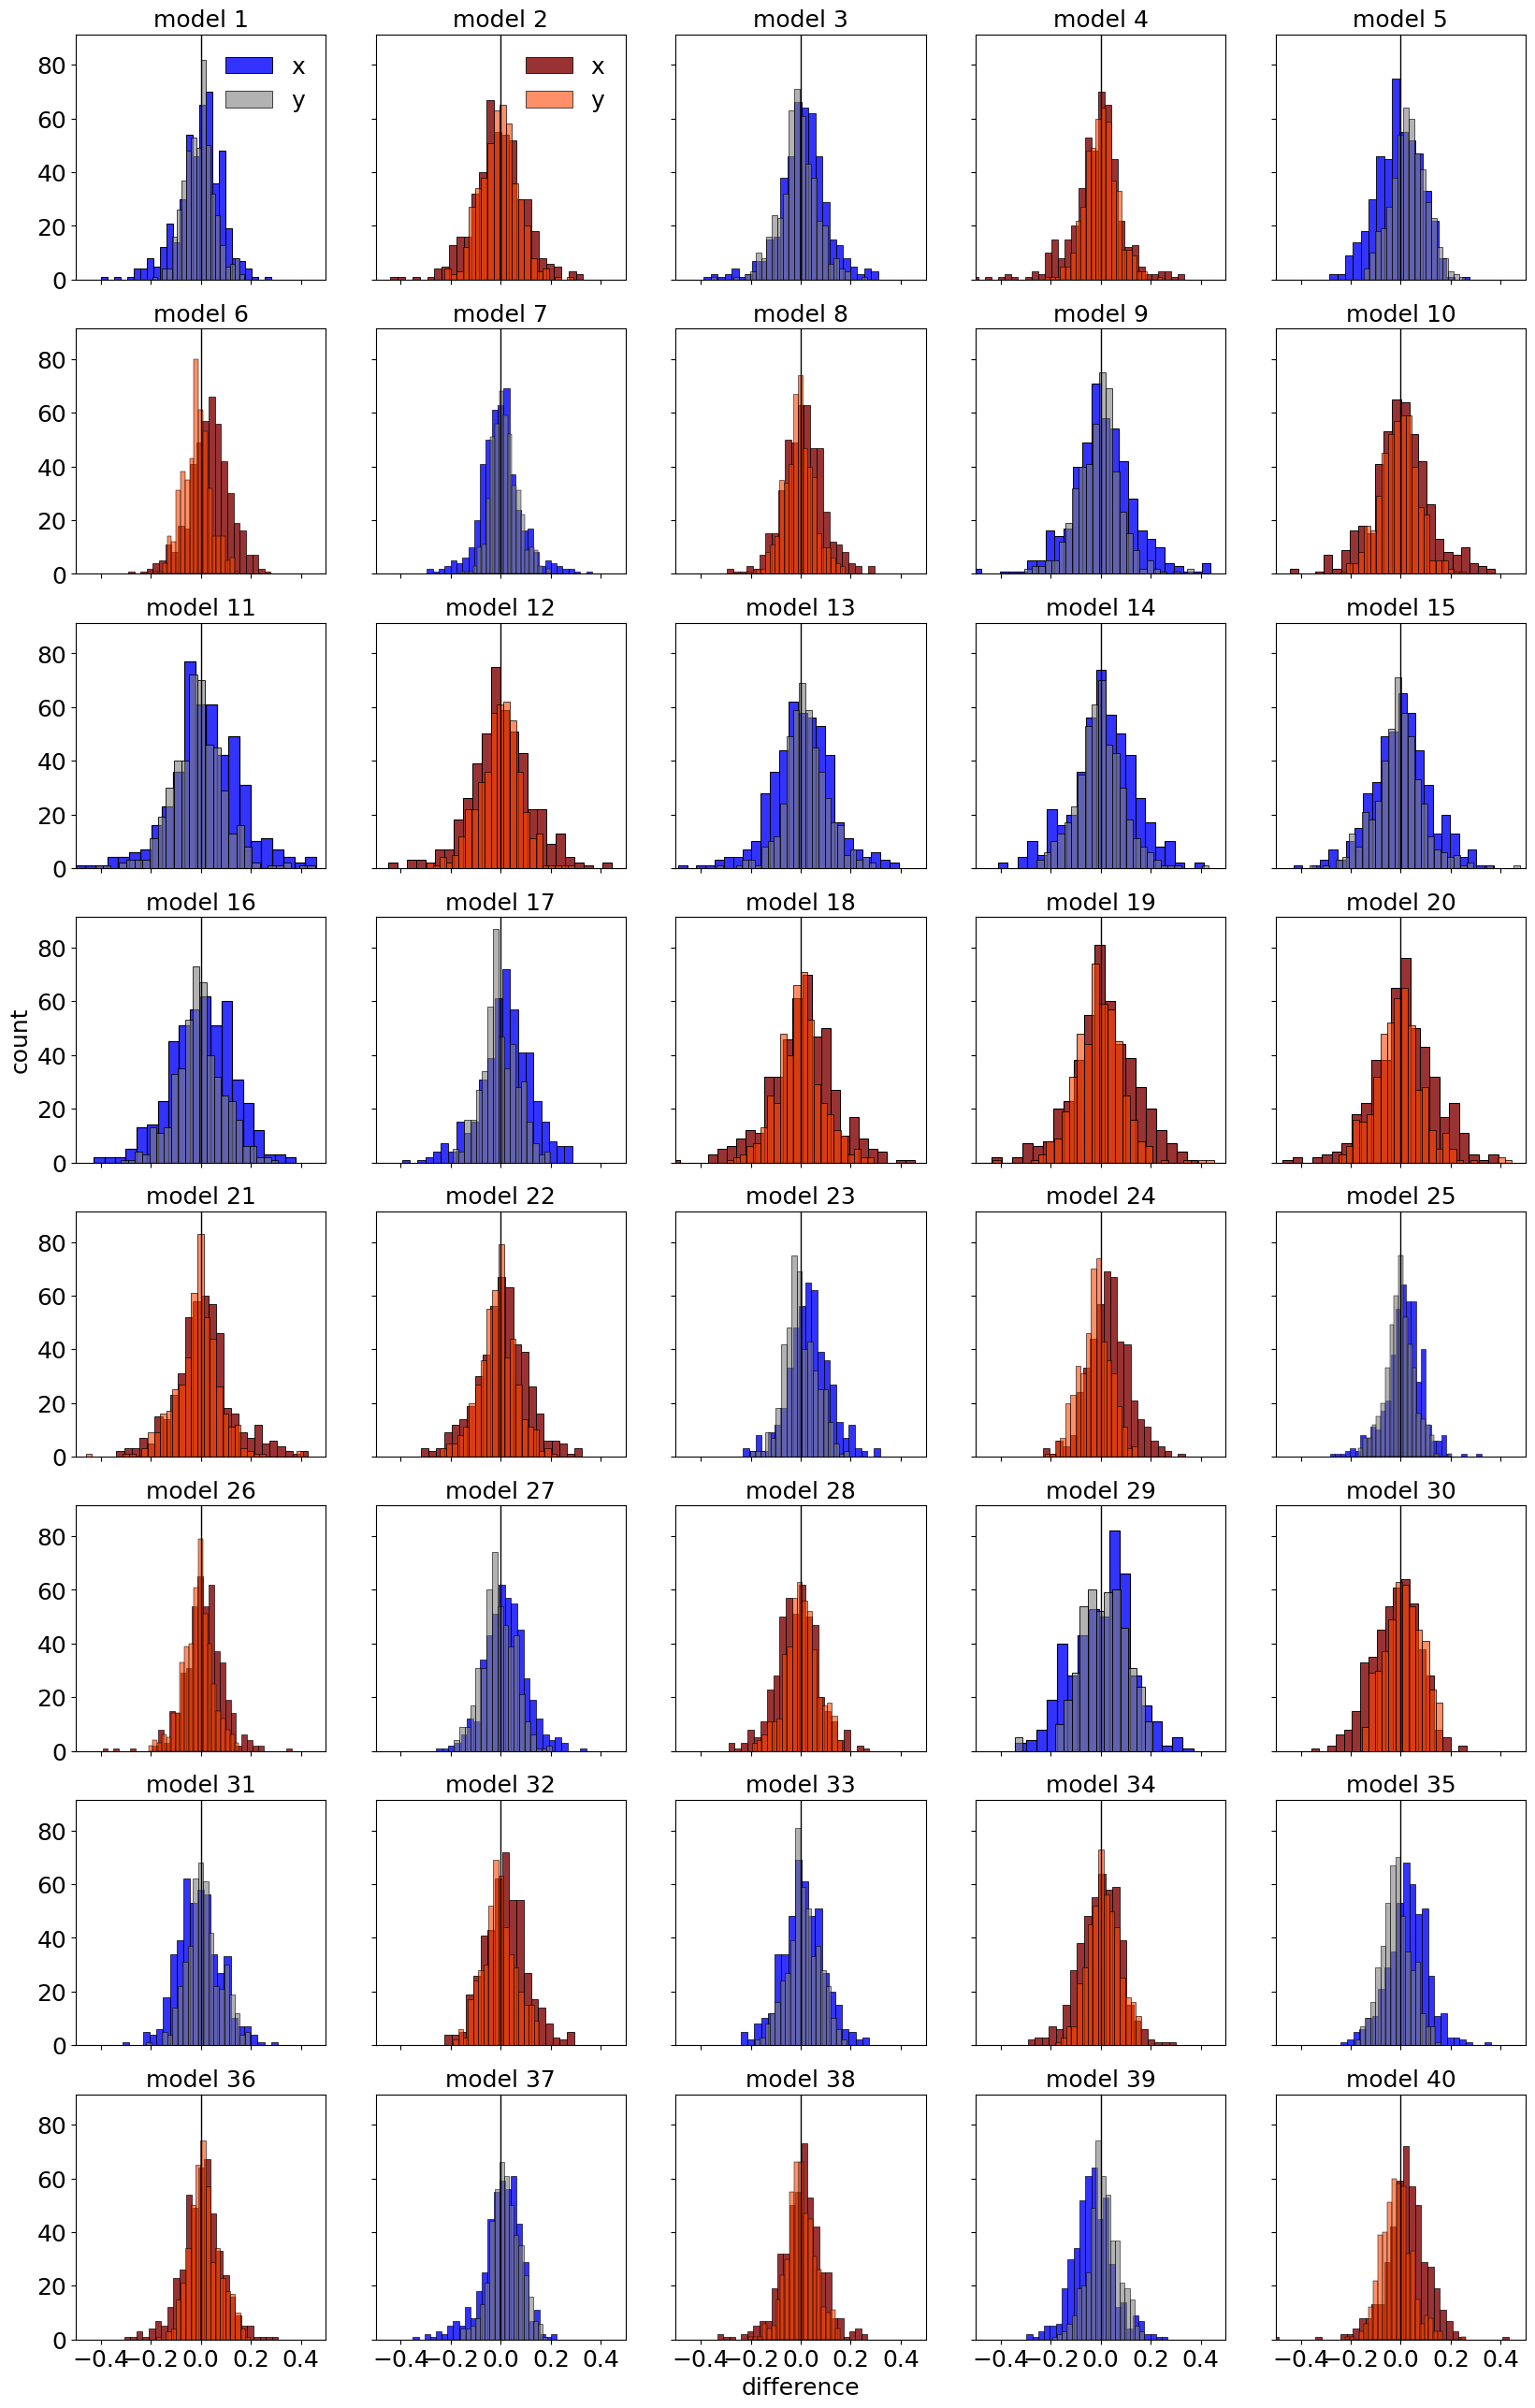

In [92]:
fig, axes = plt.subplots(nrows=8, ncols=5, figsize=(20, 32), sharex=True, sharey=True)
plt.rcParams['font.size'] = 18
for i in range(40):
    column = i%5
    row = i//5
    model_evaluation_cv(model_tuple[i], axes[row, column], i==0 or i==1, mtuple[i])
    axes[row, column].set_xlabel('')
    axes[row, column].set_title(f'model {i+1}', fontsize=18)
axes[7, 2].set_xlabel('difference')
axes[3, 0].set_ylabel('count')

#plt.savefig('model_comparison - XANES - 115.png', dpi = 1000, bbox_inches = 'tight')

Numerically, we can just calculate the MSE values:

In [94]:
def calculate_mse(y_true, y_pred):
    # Calculate mse values by comparing y_true and predictions
    return np.mean((y_true - y_pred) ** 2)

We define a "comparator" df for model comparison:

In [95]:
comparator = pd.DataFrame(columns=['model', 'activation', 'layers', 'neurons', 'mse_train', 'mse_cv', 'mse_t', 'x', 'y'])

for i, m in enumerate(mtuple):
    mse_train = calculate_mse(y_train_final, model_tuple[i].predict(X_train_final, verbose=False))
    mse_cv = calculate_mse(y_cv_final, model_tuple[i].predict(X_cv_final, verbose=False))
    mse_t = calculate_mse(y_t_final, model_tuple[i].predict(X_t_final))
    
    
    prediction = model_tuple[i].predict((X_exp['y_cor_exp'].to_numpy()).reshape(1, len(X_exp)), verbose=False)[0]
    comparator.loc[len(comparator)] = [i+1, m[0], len(m) - 1, np.sum(m[1:]), mse_train, mse_cv, mse_t, prediction[0], prediction[1]]

15/15 [==============================] - 0s 3ms/step


In order to quantify the overfitting, we calculate the MSE ratio between train and CV datasets:

In [97]:
comparator['ratio'] = comparator['mse_cv']/comparator['mse_train']

And the error:

In [98]:
comparator['error'] = comparator['mse_cv']**0.5

In [99]:
comparator.sort_values('mse_cv')

,model,activation,layers,neurons,mse_train,mse_cv,mse_t,x,y,ratio,error
24,25,relu,4,42,4.357244e-03,0.004594,0.004083,0.033874,0.046757,1.054443,0.067782
25,26,sigmoid,4,42,4.286134e-03,0.005017,0.004731,-0.013752,0.033740,1.170470,0.070829
37,38,sigmoid,5,62,3.282379e-03,0.005175,0.004689,-0.014132,0.064266,1.576679,0.071939
36,37,relu,5,62,4.286574e-03,0.005246,0.005079,0.021543,0.090377,1.223744,0.072427
6,7,relu,3,66,3.785350e-03,0.005301,0.004925,0.087659,-0.015250,1.400449,0.072809
7,8,sigmoid,3,66,3.348794e-03,0.005432,0.004747,-0.005088,-0.012562,1.622038,0.073701
35,36,sigmoid,3,50,4.207711e-03,0.005463,0.005939,0.050843,0.016073,1.298303,0.073911
34,35,relu,3,50,4.427044e-03,0.005643,0.005569,-0.075044,0.124977,1.274694,0.075121
0,1,relu,3,82,3.906294e-03,0.005721,0.005174,-0.079706,0.028167,1.464543,0.075637
33,34,sigmoid,3,26,5.225935e-03,0.005747,0.005799,-0.099347,0.127136,1.099722,0.075809


That allows us searching for the best model architecture (lowest CV MSE). More importantly, we can look at the values predicted for "x" and "y", which match our expectations.

Let's do a clearer representaiton to see where overfitting starts to occur:

Text(0.5, 0.005, 'neurons')

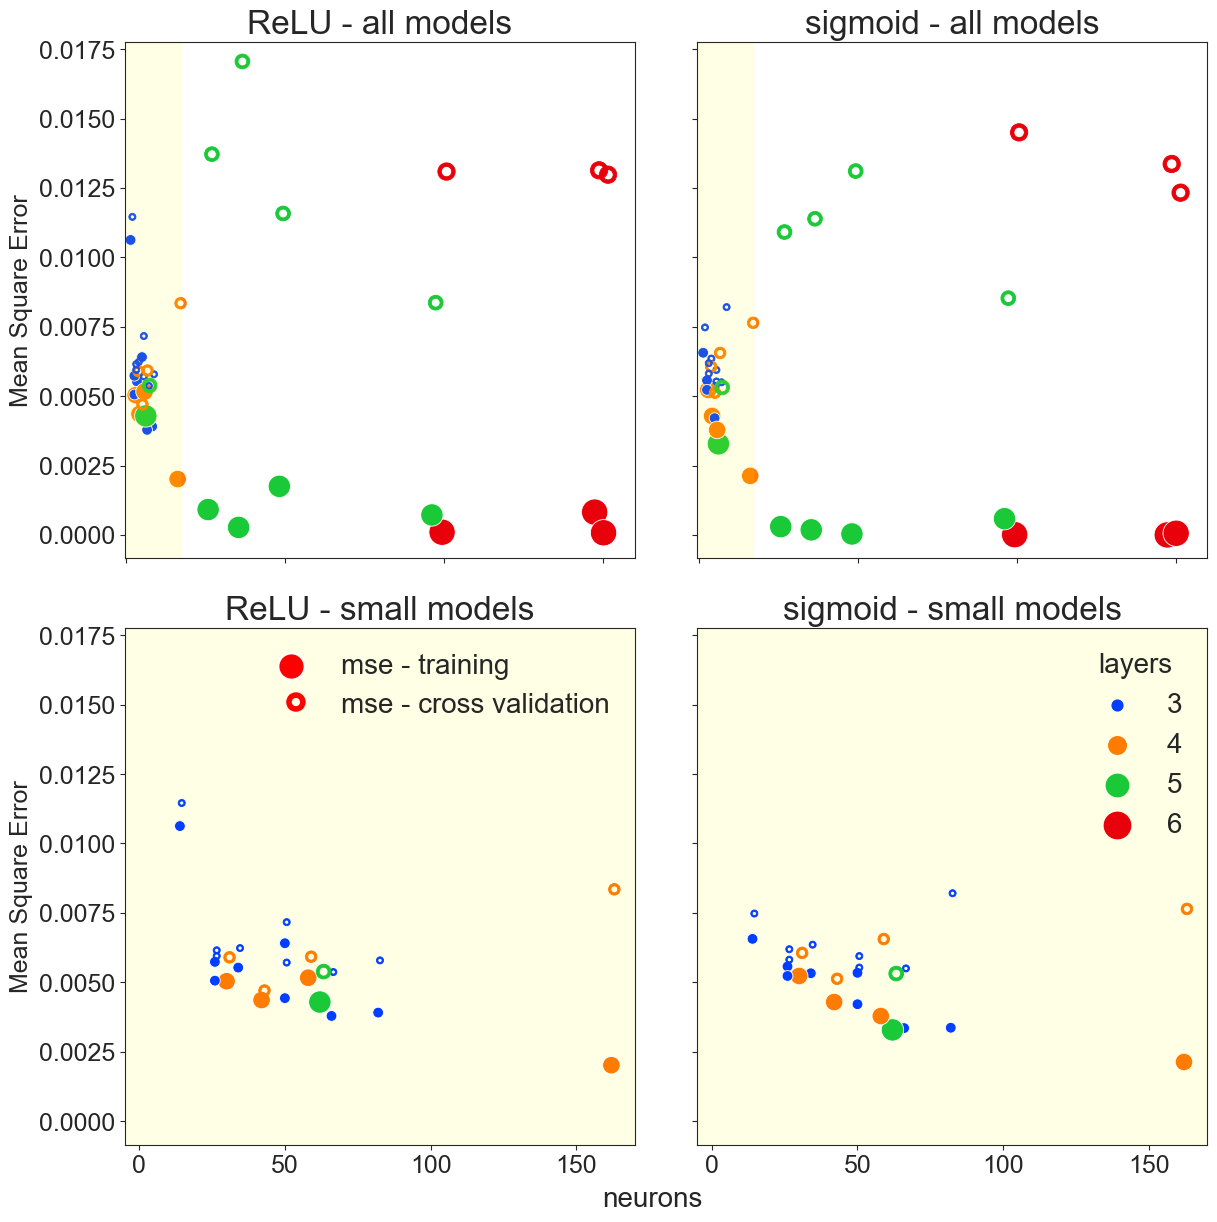

In [102]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=False, sharey=True)
sns.set_style('ticks')
plt.rcParams['font.size'] = 20
fig.tight_layout(pad=1)
axs = axes[0]

axs[0].set_ylabel('Mean Square Error')

sizes = (60, 360)

#sns.lineplot(x='neurons', y='mse_train', data=comparator[comparator['activation']=='relu'],ax=axs[0], color='grey', legend=None)
#sns.lineplot(x='neurons', y='mse_cv', data=comparator[comparator['activation']=='relu'], ax=axs[0], legend=None, color='black')

sns.scatterplot(x='neurons', y='mse_train', data=comparator[comparator['activation']=='relu'], marker='o', size='layers', hue='layers', sizes=sizes,ax=axs[0], palette='bright', legend=None)
sns.scatterplot(x='neurons', y='mse_cv', data=comparator[comparator['activation']=='relu'],ax=axs[0], marker="$\circ$", ec="face", size='layers', sizes=sizes,  hue='layers', legend=None, label=None, palette='bright')
sns.scatterplot(x='neurons', y='mse_train', data=comparator[comparator['activation']=='sigmoid'], marker='o', size='layers', hue='layers', sizes=sizes,ax=axs[1], palette='bright', legend=None)
sns.scatterplot(x='neurons', y='mse_cv', data=comparator[comparator['activation']=='sigmoid'], marker="$\circ$", ec="face", size='layers', sizes=sizes,  hue='layers', legend=None, label=None, palette='bright', ax=axs[1])

axs[0].set_title('ReLU - all models')
axs[1].set_title('sigmoid - all models')

for ax in axs:
    ax.set_xlim(-5, 1600)
    ax.set_xlabel('')
    
    ax.set_xticklabels([])
axs[0].axvspan(-5, 170, alpha=0.1, color='yellow')
axs[1].axvspan(-5, 170, alpha=0.1, color='yellow')
#sns.lineplot(x='neurons', y='mse_t', data=comparator[comparator['activation']=='relu'], ax=axs[0])
#sns.lineplot(x='neurons', y='mse_train', data=comparator[comparator['activation']=='sigmoid'],ax=axs[1], color='grey', legend=None)
#sns.lineplot(x='neurons', y='mse_cv', data=comparator[comparator['activation']=='sigmoid'], ax=axs[1], legend=None, color='black')


axs = axes[1]


axs[0].set_ylabel('Mean Square Error')
axs[0].set_title('ReLU - small models')
axs[1].set_title('sigmoid - small models')


axs[0].axvspan(-5, 170, alpha=0.1, color='yellow')
axs[1].axvspan(-5, 170, alpha=0.1, color='yellow')

sns.scatterplot(x='neurons', y='mse_train', data=comparator[comparator['activation']=='relu'], marker='o', size='layers', hue='layers', sizes=sizes,ax=axs[0], palette='bright', legend=None)
sns.scatterplot(x='neurons', y='mse_cv', data=comparator[comparator['activation']=='relu'],ax=axs[0], marker="$\circ$", ec="face", size='layers', sizes=sizes,  hue='layers', legend=None, label=None, palette='bright')
sns.scatterplot(x='neurons', y='mse_train', data=comparator[comparator['activation']=='sigmoid'], marker='o', size='layers', hue='layers', sizes=sizes,ax=axs[1], palette='bright')
sns.scatterplot(x='neurons', y='mse_cv', data=comparator[comparator['activation']=='sigmoid'], marker="$\circ$", ec="face", size='layers', sizes=sizes,  hue='layers', legend=None, label=None, palette='bright', ax=axs[1])
axs[1].legend(frameon=False, title='layers')
sns.scatterplot(x=[comparator.loc[15]['neurons'],], y=[comparator.loc[15]['mse_train'],], marker='o', s=sizes[1], legend=None, label='mse - training', color='red', ax=axs[0])
sns.scatterplot(x=[comparator.loc[15]['neurons'],], y=[comparator.loc[15]['mse_cv'],], marker="$\circ$", ec="face", s=sizes[1], legend=None, label='mse - cross validation', color='red', ax=axs[0])
axs[0].legend(frameon=False, loc='upper right')

for ax in axs:
    ax.set_xlim(-5, 170)
    ax.set_xlabel('')

fig.text(0.5, 0.005, 'neurons', ha='center', va='center', fontsize=20)
#plt.savefig('NN models for XANES.png', dpi = 1000, bbox_inches = 'tight')

Overfitting clearly occurs above 100 neurons, where MSE values skyrocket. This can be better seen by analysing the ratio between CV and train datasets:

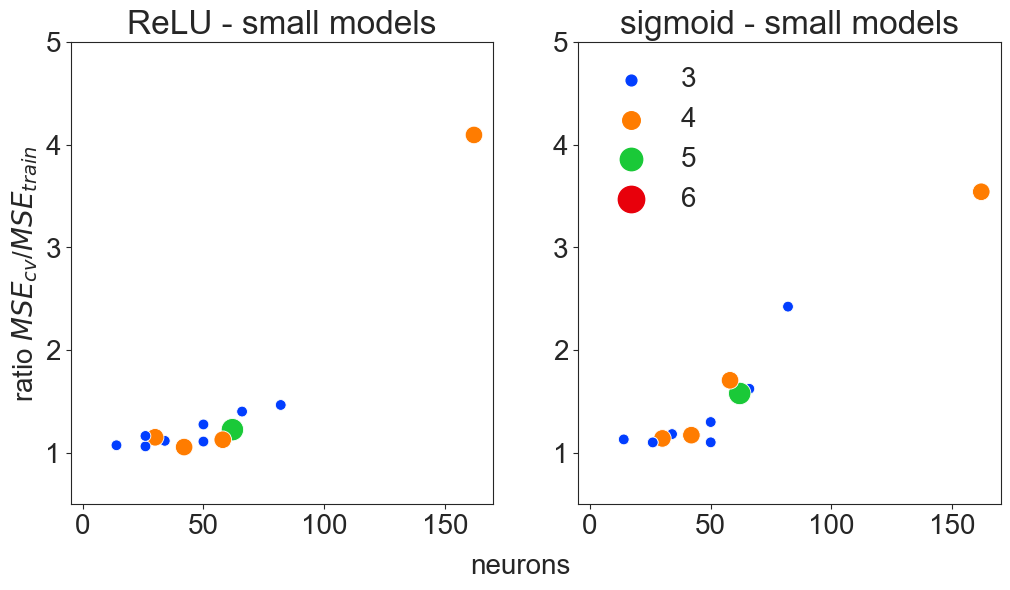

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.scatterplot(x='neurons', y='ratio', data=comparator[comparator['activation']=='relu'],marker='o', size='layers', sizes=sizes, hue='layers', legend=None, label='mse - training', palette='bright', ax=axs[0])
sns.scatterplot(x='neurons', y='ratio', data=comparator[comparator['activation']=='sigmoid'], marker='o', size='layers', sizes=sizes, hue='layers', palette='bright', ax=axs[1])


axs[0].set_ylabel(r'ratio $MSE_{cv}$/$MSE_{train}$')
axs[1].set_ylabel('')
axs[0].set_title('ReLU - small models')
axs[1].set_title('sigmoid - small models')


fig.text(0.5, 0.005, 'neurons', ha='center', va='center', fontsize=20)
for ax in axs:
    ax.set_ylim(0.5, 5)
    ax.set_xlim(-5, 170)
    ax.set_xlabel('')
axs[1].legend(frameon=False)
#plt.savefig('ratio values for XANES.png', dpi = 1000, bbox_inches = 'tight')

In [104]:
comparator.sort_values('mse_cv').head()

,model,activation,layers,neurons,mse_train,mse_cv,mse_t,x,y,ratio,error
24,25,relu,4,42,0.004357,0.004594,0.004083,0.033874,0.046757,1.054443,0.067782
25,26,sigmoid,4,42,0.004286,0.005017,0.004731,-0.013752,0.033740,1.170470,0.070829
37,38,sigmoid,5,62,0.003282,0.005175,0.004689,-0.014132,0.064266,1.576679,0.071939
36,37,relu,5,62,0.004287,0.005246,0.005079,0.021543,0.090377,1.223744,0.072427
6,7,relu,3,66,0.003785,0.005301,0.004925,0.087659,-0.015250,1.400449,0.072809


In [111]:
X_exp = scan_treat(109, 'roi3', 10, 2, 10)
model_25.predict((X_exp['y_cor_exp'].to_numpy()).reshape(1, len(X_exp)), verbose=False)[0]

array([ 0.03374686, -0.00627191], dtype=float32)

***

In summary, in this notebook:
- We have proposed 40 different architectures to tackle the problem of the refinement of REXS spectra.
- We have found the models which fit the best the data, i.e., those leading to the smalles CV MSE.
- The values obtained for the best models all lead to sensible values for the cationic occupations. This strategy seems robust, precise; with the advantage of giving values almost with no computational cost once the models have been trained.

By Antonio Peña Corredor